In [1]:
%cd ..

/home/jairo/Documentos/GitHub/parallel-kink-scattering


/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.signal import find_peaks
# from scipy.optimize import curve_fit
from pathlib import Path
import multiprocessing as mp
import os

from modules.numerical import *

In [3]:
class Config:
    L = 50
    N = int((5/4)*1000)
    dx = 2*L/N
    dt = 0.7*dx

    x_lattice = Lattice(x=(-L, L, dx))
    cm_index = x_lattice.at(x=0)
    collider = KinkCollider(
        x_lattice = x_lattice,
        dt = dt
    )

    v_min = 0.05
    v_max = 0.5
    v_lims = (v_min, v_max)

    lamb_min = 0.075
    lamb_max = 50
    lamb_lims = (lamb_min, lamb_max)

    separation_by_delta = 10

    save_dir = Path('data/new-dataset')
    # save_dir.mkdir(exist_ok= True)
    # info_path = save_dir/'info.csv'

def t_final(v, lamb):
    x0 = Config.separation_by_delta*delta/2
    return 2*x0/v + Config.L

In [4]:
files = tuple(Config.save_dir.glob('*'))
len(files)

69163

In [5]:
i = np.random.randint(len(files))
y_cm, k = pd.read_csv(files[i]).values.T

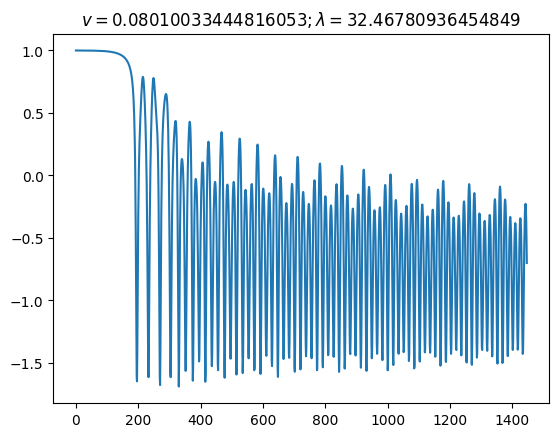

In [6]:
plt.plot(y_cm)
plt.title(r'$v={}; \lambda={}$'.format(*files[i].stem.split('-')[:2]))
plt.show()

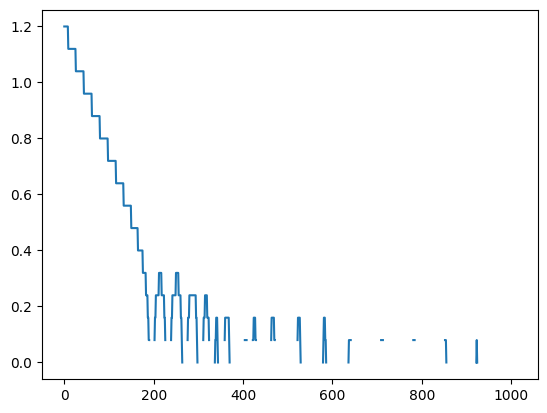

In [7]:
plt.plot(k)

In [8]:
summary = pd.DataFrame([tuple(map(float, filename.stem.split('-'))) for filename in files], columns=('v', 'lamb', 'exec_time', 'delay'))
summary

,v,lamb,exec_time,delay
0,0.354013,15.603512,6212.099242,21.960698
1,0.250167,6.753930,5162.126230,28.683505
2,0.211037,15.770485,3709.034960,26.240957
3,0.475920,11.262207,8607.232753,22.343810
4,0.474415,2.913545,10799.342024,26.826434
...,...,...,...,...
69158,0.409699,37.310033,6645.066856,23.860342
69159,0.326923,31.966890,5426.424412,25.620587
69160,0.363043,32.467809,5972.148770,23.260959
69161,0.274247,15.269565,4897.823551,28.805936


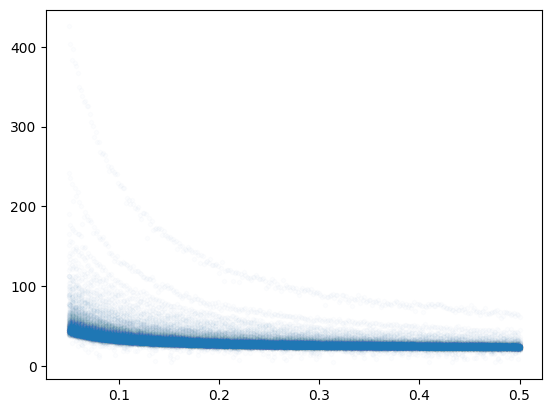

In [48]:
plt.plot(summary.v, summary.delay, '.', alpha=0.01)

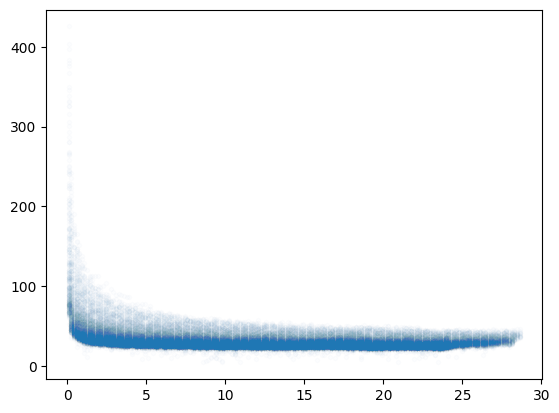

In [27]:
plt.plot(summary.lamb, summary.delay, '.', alpha=0.01)

In [9]:
mosaic = np.full((300, 300), np.nan)
mosaic.shape

(300, 300)

In [47]:
files = tuple(Config.save_dir.glob('*'))
len_files = len(files)
print(len_files)
vs = np.linspace(*Config.v_lims, 300)
lambs = np.linspace(*Config.lamb_lims, 300)
for i, filename in enumerate(files):
    print(str(i/len_files*100), end='\r')
    v, lamb = tuple(map(float, filename.stem.split('-')))[:2]
    j, k = np.argwhere(vs == v), np.argwhere(lambs == lamb)
    if np.any(np.isnan(mosaic[j, k])):
        with open(filename) as f:
            for row in f: pass
            try: mosaic[j, k] = float(row.split(',')[0])
            except ValueError: pass

90000


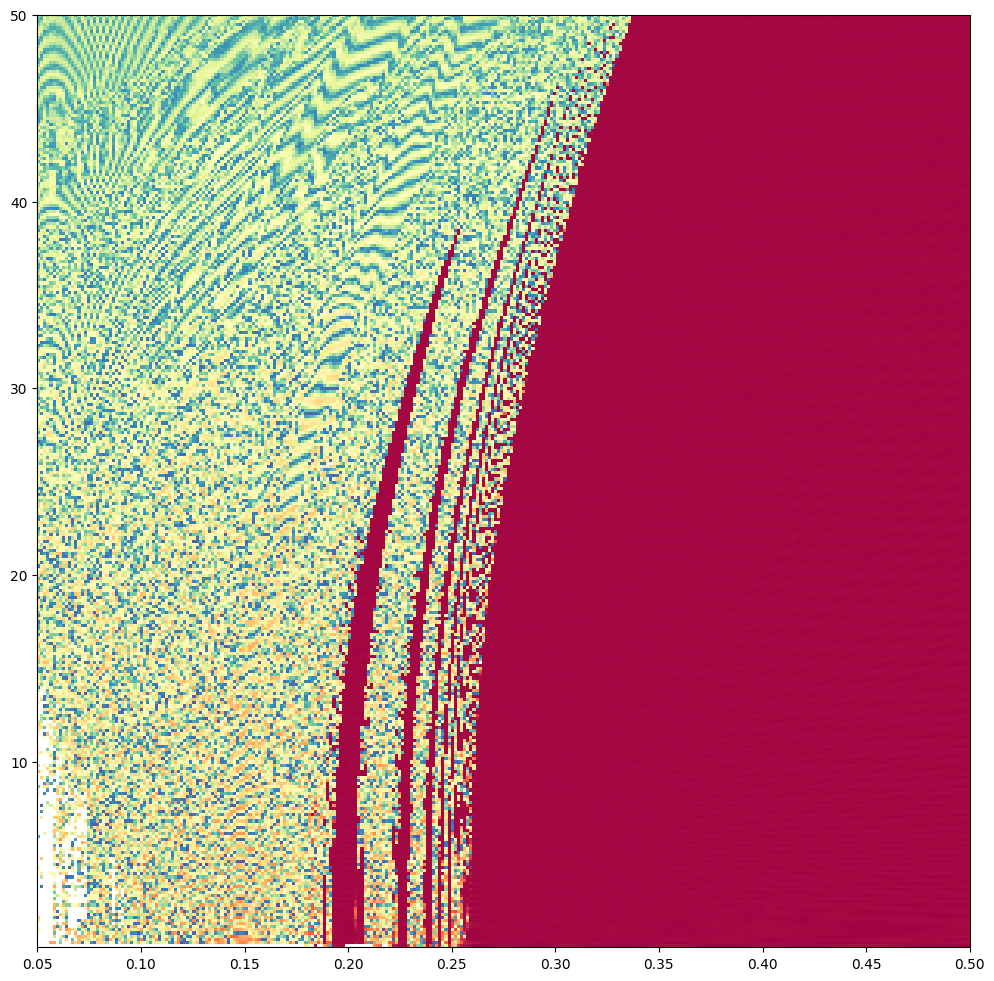

In [73]:
plt.figure(figsize=(10,10))
plt.imshow(mosaic.T, 
    extent=(*Config.v_lims, *Config.lamb_lims), 
    cmap='Spectral_r', 
    aspect=(Config.v_max - Config.v_min)/(Config.lamb_max - Config.lamb_min), 
    origin='lower', 
    resample=False,
    # vmin=-2, vmax=2
)
plt.gcf().tight_layout()
plt.show()

In [74]:
mosaic_df = pd.DataFrame(mosaic, index=vs, columns=lambs)
mosaic_df

,0.075000,0.241973,0.408946,0.575920,0.742893,0.909866,1.076839,1.243813,1.410786,1.577759,...,48.497241,48.664214,48.831187,48.998161,49.165134,49.332107,49.499080,49.666054,49.833027,50.000000
0.050000,NaN,NaN,NaN,NaN,NaN,-0.375789,NaN,NaN,-0.576974,0.025057,...,-1.304620,-1.305779,-1.044252,-0.583999,-0.564481,-0.671419,-0.981093,-1.199113,-1.132532,-0.936474
0.051505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.719531,-1.160546,-1.282513,-0.992360,-0.651297,-0.607775,-0.773175,-0.954717,-1.266648,-1.082861
0.053010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.614687,-0.552401,-0.814627,-1.217465,-1.321927,-0.858094,-0.944076,-0.593431,-0.618607,-0.694554
0.054515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.671359,-0.653733,-0.831557,-1.081120,-1.241610,-1.002341,-0.776188,-0.681021,-0.786934,-0.832722
0.056020,NaN,0.262860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.836600,-0.646148,-0.671743,-0.797035,-1.137877,-1.235845,-1.111303,-0.745698,-0.650791,-0.651097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.493980,1.020582,0.984761,1.008176,0.981739,1.001573,0.994759,0.995243,0.991291,0.992423,1.009858,...,0.998112,0.993408,0.996165,0.998967,1.004538,1.004581,1.000621,0.998017,0.998326,0.998424
0.495485,1.020066,0.982691,1.009472,0.979966,1.002179,0.994604,0.993849,0.988391,0.991845,1.009190,...,0.999742,0.997379,0.993897,0.996903,1.003606,1.006384,1.002278,0.996843,0.996281,0.997607
0.496990,1.019587,0.981222,1.009792,0.978397,1.002016,0.993685,0.990760,0.986814,0.990944,1.008409,...,1.000801,0.998977,0.996009,0.996357,1.001534,1.006233,1.004092,1.001163,0.995361,0.996004
0.498495,1.018999,0.979772,1.009971,0.977073,1.001621,0.993169,0.989579,0.985234,0.989962,1.007579,...,0.998044,0.998529,0.998358,0.997867,1.000219,1.002300,1.005863,1.002563,0.995645,0.994498


In [75]:
mosaic_df.to_csv('data/mosaic.csv')

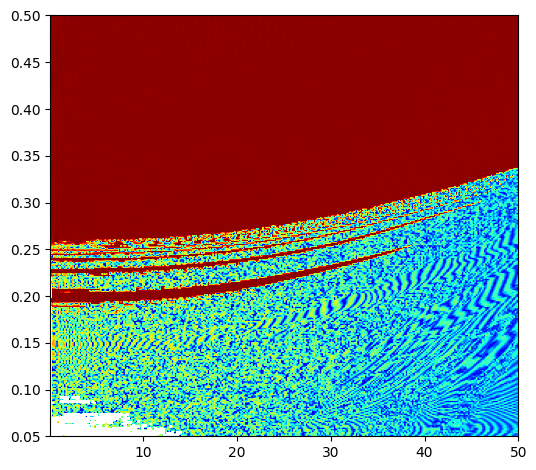

In [76]:
# plt.figure(figsize=(10,10))
plt.imshow(mosaic_df.values, extent=(mosaic_df.columns.min(), mosaic_df.columns.max(), mosaic_df.index.min(), mosaic_df.index.max()), cmap='jet', 
    aspect=(Config.lamb_max - Config.lamb_min)/Config.v_max - Config.v_min, origin='lower')
plt.gcf().tight_layout()
plt.show()

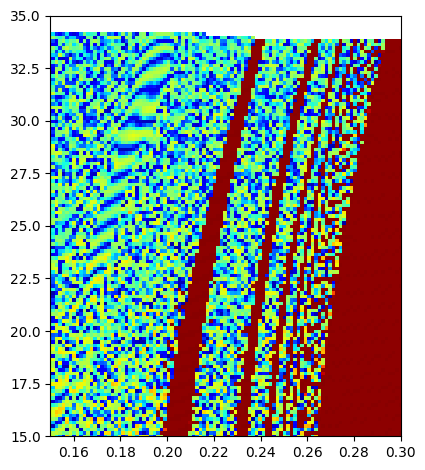

In [113]:
plt.imshow(mosaic.T, extent=(*Config.v_lims, *Config.lamb_lims), cmap='jet', 
    aspect=(Config.v_max - Config.v_min)/(Config.lamb_max - Config.lamb_min), origin='lower')

plt.xlim(0.15, 0.3)
plt.ylim(15, 35)

plt.gcf().tight_layout()
plt.show()

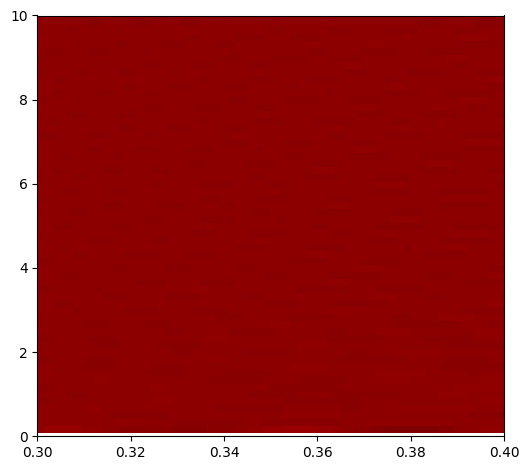

In [104]:
plt.imshow(mosaic.T, extent=(*Config.v_lims, *Config.lamb_lims), cmap='jet', aspect=(Config.v_max - Config.v_min)/(Config.lamb_max - Config.lamb_min), origin='lower')
plt.xlim(0.3, 0.4)
plt.ylim(0, 10)
plt.gcf().tight_layout()
plt.show()

In [ ]:
from matplotlib.colors import ListedColormap

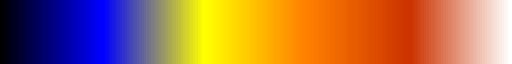

In [ ]:

def color_mapping(N, colors):
    n = N//len(colors)
    output = []
    for c1, c2 in zip(colors[:-1], colors[1:]):
        output += np.stack([np.linspace(v1, v2, n) for v1, v2 in zip(c1, c2)], axis=-1).tolist()
    return output

cmap = ListedColormap(color_mapping(255, [
    (0,0,0),
    (0,0,1),
    (1,1,0),
    (1,0.5,0),
    (0.8,0.2,0),
    (1,1,1),
]))
cmap

In [14]:
import psutil
import pandas as pd

In [15]:
for k, v in psutil.sensors_temperatures().items(): print(k); print(pd.DataFrame(v))

enp7s0
             label  current  high critical
0  PHY Temperature   63.207  None     None
1  MAC Temperature   69.474  None     None
nvme
       label  current    high  critical
0  Composite    38.85  117.85    149.85
coretemp
           label  current  high  critical
0   Package id 0     59.0  72.0      82.0
1        Core 11     54.0  72.0      82.0
2        Core 16     53.0  72.0      82.0
3        Core 17     53.0  72.0      82.0
4        Core 18     52.0  72.0      82.0
5        Core 19     56.0  72.0      82.0
6        Core 20     55.0  72.0      82.0
7        Core 24     55.0  72.0      82.0
8        Core 25     57.0  72.0      82.0
9        Core 26     54.0  72.0      82.0
10       Core 27     54.0  72.0      82.0
11        Core 0     52.0  72.0      82.0
12        Core 1     51.0  72.0      82.0
13        Core 2     58.0  72.0      82.0
14        Core 3     56.0  72.0      82.0
15        Core 4     56.0  72.0      82.0
16        Core 8     55.0  72.0      82.0
17        Core

In [3]:
def read(filename):
    return pd.read_csv(filename, index_col=0)

def imshow(y, x, t, ax=None, **kwargs):
    (plt if ax == None else ax).imshow(y, extent=(t.min(), t.max(), x.min(), x.max()), origin='lower', **kwargs)

In [4]:
path = Path('data/dataset/')
files = tuple(path.glob('*'))

In [7]:
i = np.random.randint(len(files))
df = read(files[i]).T
y = df.values
t = df.index.values.astype(float)
x = df.columns.values.astype(float)
lat = Lattice()
lat.ranges = [t, x]

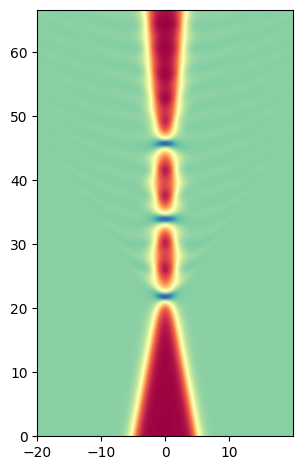

In [24]:
_, wx = lat.window(..., (-20, 20))
imshow(y[:, wx], t, x[wx], cmap='Spectral_r', aspect='equal')

plt.gcf().tight_layout()
plt.show()

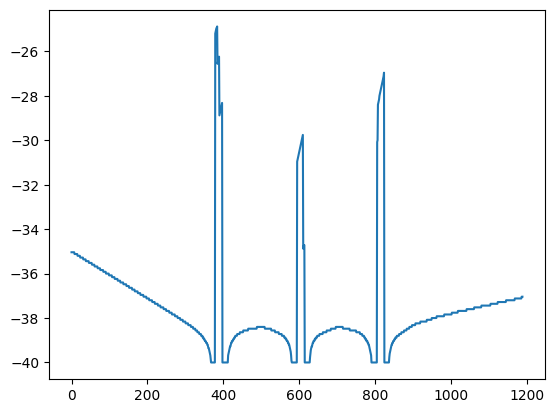

In [66]:
plt.plot([x[np.argmin(np.abs(yi))] for yi in y[:, lat.at(..., 0)[1]:]])

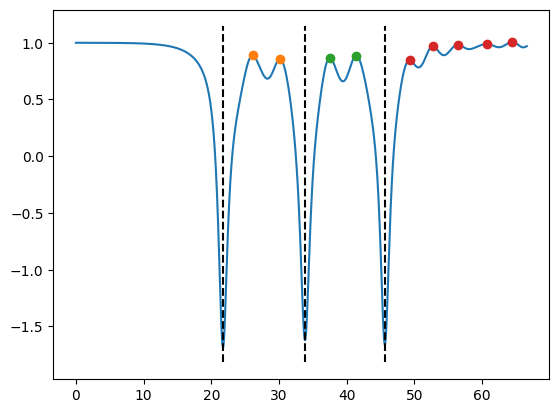

In [25]:
cm = y[*lat.at(..., 0)]
peaks, _ = find_peaks(cm**2, prominence=1.5)

plt.plot(t, cm)
plt.vlines(t[peaks], *plt.gca().get_ylim(), colors='k', linestyles='dashed')

for i in range(len(peaks) - 1):
    bounce = (t > t[peaks][i]) & (t < t[peaks][i+1])
    mini_peaks, _ = find_peaks(cm[bounce])
    plt.plot(t[bounce][mini_peaks], cm[bounce][mini_peaks], 'o')
bounce = t > t[peaks][-1]
mini_peaks, _ = find_peaks(cm[bounce])
plt.plot(t[bounce][mini_peaks], cm[bounce][mini_peaks], 'o')

plt.show()

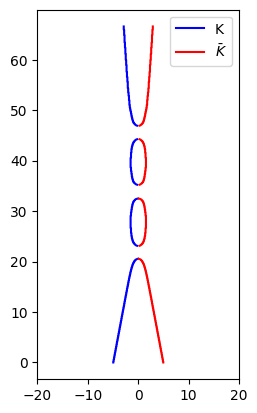

In [26]:
k1, k2 = [], []
for i in range(len(t)):
    x_slice = x[y[i] >= 0]
    if len(x_slice) == 0:
        k1.append(np.nan)
        k2.append(np.nan)
    else:
        k1.append(x_slice.min())
        k2.append(x_slice.max())
k1, k2 = np.r_[k1], np.r_[k2]

plt.plot(k1, t, 'b-', label=r'K')
plt.plot(k2, t, 'r-', label=r'$\bar{K}$')
plt.legend()
plt.gca().set_aspect('equal')
plt.xlim(-20, 20)

plt.show()

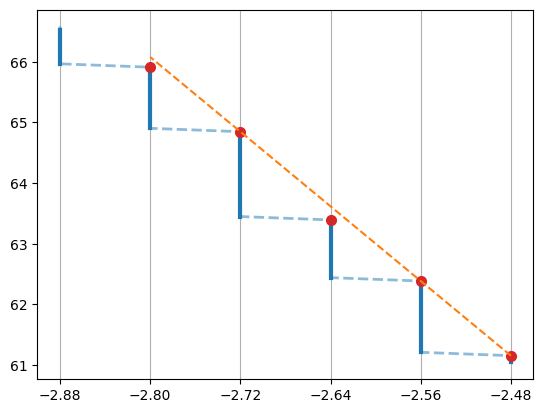

In [27]:
Q = 100
plt.plot(k1[-Q:], t[-Q:], 'C0--', lw=2, alpha=0.5)

vs = np.diff(k1[-Q:])
for slc in np.ma.clump_masked(np.ma.masked_equal(vs, 0)):
    plt.plot(k1[-Q:][slc], t[-Q:][slc], 'C0-', lw=3)

vertex = np.argwhere(vs != 0).ravel()
plt.plot(k1[-Q:][vertex], t[-Q:][vertex], 'C3o', markersize=7) # t = ax + b => b = t - ax

v1, v2 = vertex[:2]
delta_t = -t[-Q:][v2] + t[-Q:][v1]
dx = x[1] - x[0]
a = delta_t/dx

b = t[-Q:][vertex[0]] - k1[-Q:][vertex[0]]*a
X_v = np.linspace(k1[-Q:][vertex[0]], k1[-Q:][vertex[-1]], 25)
plt.plot(X_v, X_v*a + b, 'C1--')

# plt.legend()
plt.grid(axis='x')
k1_unique = np.unique(k1[-Q:])
plt.xticks(k1_unique[~np.isnan(k1_unique)])
plt.show()

2.857142857142749
2.8571428571429305
1.4285714285714648
-0.07518796992481394
-2.857142857142749
-2.8571428571429296
-1.4285714285714648
0.07518796992481436


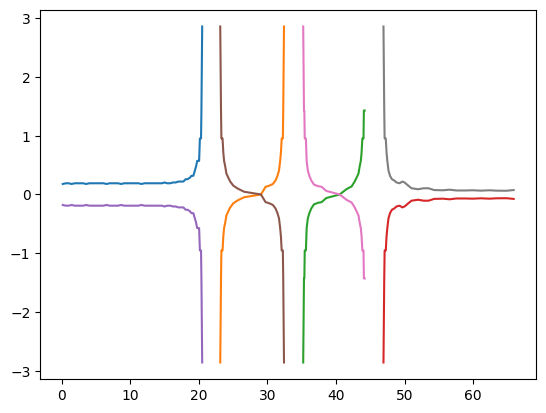

In [47]:
for k in (k1, k2):
    for slc in np.ma.clump_unmasked(np.ma.masked_invalid(k)):
        vertex = np.argwhere(np.diff(k[slc]) != 0)
        V = np.gradient(k[slc][vertex].ravel())/np.gradient(t[slc][vertex].ravel())
        plt.plot(t[slc][vertex].ravel(), V)
        print(V[-1])
plt.show()

In [59]:
c = lat.at(..., 0)[1]
y_lb = y[peaks[-1]:, c:] >= 0
x_lb = lat[1][c:]

x_ve = []
while len(x_ve < ):
    xi_ = x_lb[y_lb[-i]].max()
    if xi_ != xi: break
    else: i += 1

(xi_ - xi)/(lat[0][-i] - lat[0][-1])

0.11904761904762141

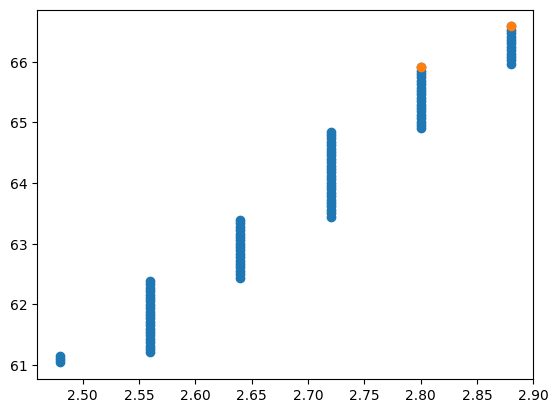

In [61]:
plt.plot(k2[-100:], t[-100:], 'o')
plt.plot((xi_, xi), (lat[0][-i], lat[0][-1]), 'o')

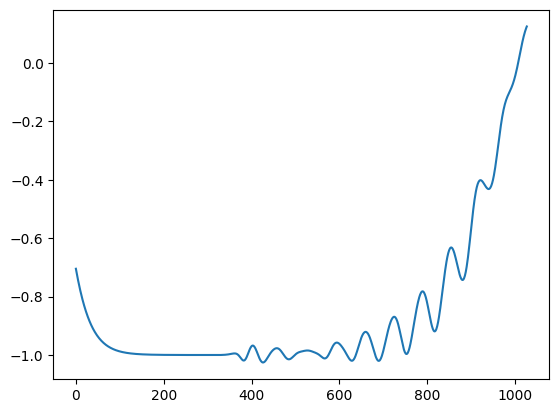

In [19]:
y_dx1 = y[*lat.at(..., k1 + np.diff(lat.ranges[1])[-1])]
plt.plot()

In [11]:
path = Path('data/dataset2')
files = tuple(path.glob('*'))
len(files)

2000

In [12]:
read(files[0])

,y_cm,k
0.000,0.999998,-30.00
0.056,0.999998,-30.00
0.112,0.999998,-30.00
0.168,0.999998,-30.08
0.224,0.999998,-30.08
...,...,...
114.184,1.005624,-28.24
114.240,1.005954,-28.24
114.296,1.006198,-28.16
114.352,1.006354,-28.16


In [13]:
files[0].stem

'0.29079539769884943-1'

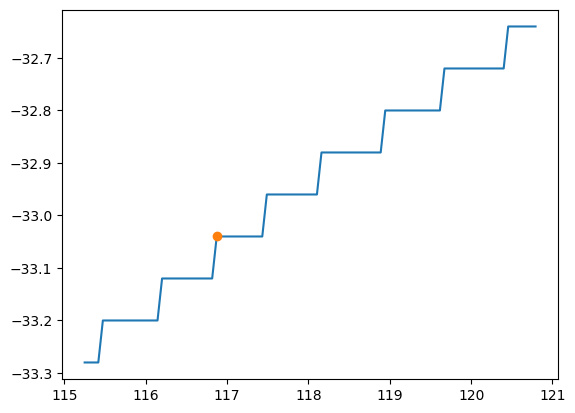

In [14]:
df = read(files[100])
t = df.index.astype(float)
plt.plot(t[-100:], df.k.values[-100:])
vex = np.argwhere(df.k.diff().values[-100:] != 0)
plt.plot(t[-100:][vex[2]], df.k.values[-100:][vex[2]], 'o')

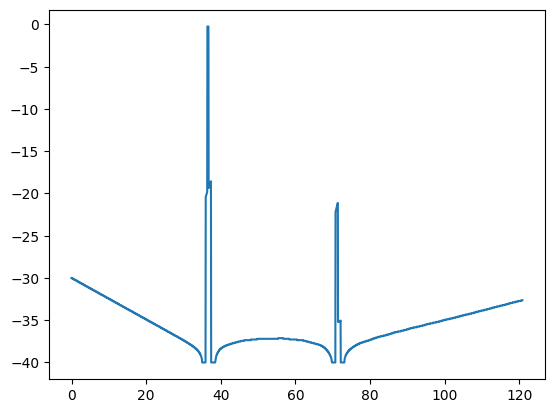

In [15]:
plt.plot(t, df.k)

In [16]:
V = []
N = []
V_out = []

for filename in files:
    V.append(float(filename.stem.split('-')[0]))
    df = read(filename)
    t = df.index.values.astype(float)
    k = df.k.values

    peaks, _ = find_peaks(df.y_cm**2, prominence=1.5)
    N.append(len(peaks))
    
    v = np.argwhere(df.k.diff() != 0)
    V_out.append(np.abs(np.diff(k[v])/np.diff(t[v])).mean())
    
V = np.r_[V]
N = np.r_[N]
V_out = np.r_[V_out]

/tmp/ipykernel_5557/644041635.py:15: RuntimeWarning: Mean of empty slice.
  V_out.append(np.abs(np.diff(k[v])/np.diff(t[v])).mean())
/home/jairo/Documentos/GitHub/kink-antikink-parellel/.env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5557/644041635.py:15: RuntimeWarning: Mean of empty slice.
  V_out.append(np.abs(np.diff(k[v])/np.diff(t[v])).mean())
/home/jairo/Documentos/GitHub/kink-antikink-parellel/.env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5557/644041635.py:15: RuntimeWarning: Mean of empty slice.
  V_out.append(np.abs(np.diff(k[v])/np.diff(t[v])).mean())
/home/jairo/Documentos/GitHub/kink-antikink-parellel/.env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret

Text(0, 0.5, '$N$')

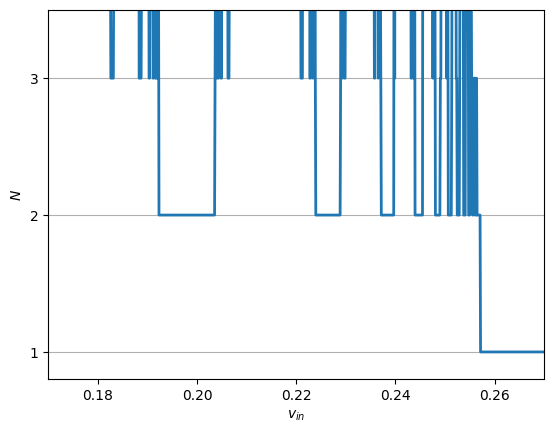

In [22]:
sort = np.argsort(V)
plt.plot(V[sort], N[sort], lw=2)
plt.ylim(0.8, 3.5)
plt.xlim(0.17, 0.27)
plt.yticks([1, 2, 3])
plt.grid(axis='y')
plt.xlabel(r'$v_{in}$')
plt.ylabel(r'$N$')

(0.0, 1.0)

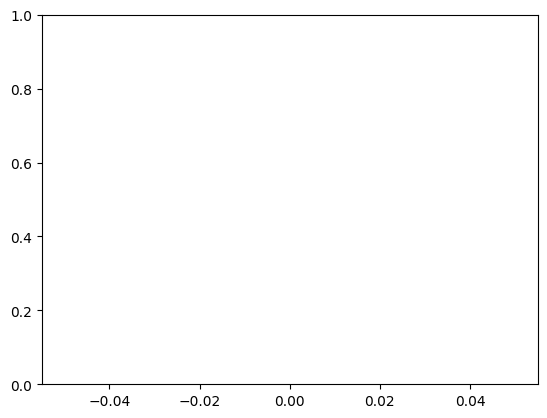

In [95]:
sort = np.argsort(V)
loc = N[sort] == 2
plt.plot(V[sort][loc], V_out[sort][loc], '-')
plt.ylim(0, 1)

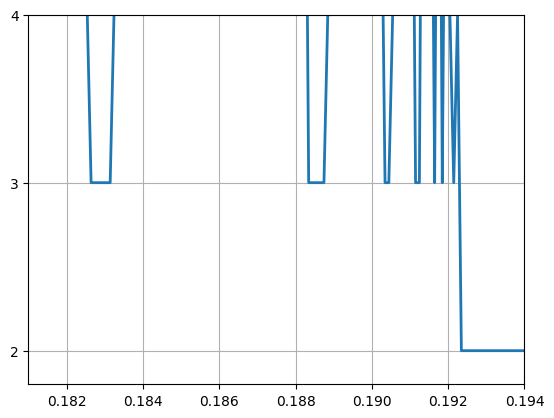

In [74]:
sort = np.argsort(V)
plt.plot(V[sort], N[sort], lw=2)
plt.ylim(1.8, 4)
plt.xlim(0.181, 0.194)
plt.yticks([2, 3, 4])
plt.grid()

In [5]:
from celluloid import Camera
from IPython.display import HTML

def show(animation):
    plt.close()
    return HTML(animation.to_html5_video())

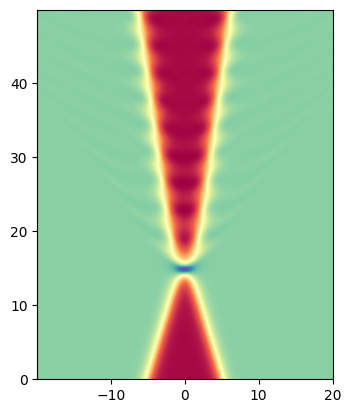

In [9]:
fig = plt.figure()
fig.tight_layout()

camera = Camera(fig)

vs = [float(filename.stem.split('-v:')[-1]) for filename in files]
x = np.arange(-40, 40, 2*40/1000)
w = (x >= -20) & (x <= 20)
for i in np.argsort(vs):
    df = read(files[i]).T
    y = df.values
    t = df.index.values.astype(float)
    loc = t < 50
    imshow(y[loc][:, w], t[loc], x[w], cmap='Spectral_r', aspect='equal')
    camera.snap()

In [10]:
show(camera.animate(interval=10))